In [90]:
import io
import os
import re
import shutil
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from tensorflow import keras
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

tf.config.run_functions_eagerly(True)

In [91]:
def fix_df(df: pd.DataFrame) -> pd.DataFrame:
  df['left_word'] = df['left_word'].fillna('nan')
  df['right_word'] = df['right_word'].fillna('nan')
  return df.dropna()

In [92]:
train_df = pd.read_csv('train_extra.csv')
valid_df = pd.read_csv('valid_extra.csv')
test_df = pd.read_csv('test_extra.csv')

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 707210 entries, 0 to 707209
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   left_synset_id     707210 non-null  int64 
 1   relation           707210 non-null  object
 2   right_synset_id    707210 non-null  int64 
 3   is_valid           707210 non-null  int64 
 4   left_definition    707210 non-null  object
 5   left_word          707196 non-null  object
 6   left_POS_tag       707210 non-null  object
 7   left_sense_index   707210 non-null  int64 
 8   right_definition   707210 non-null  object
 9   right_word         707194 non-null  object
 10  right_POS_tag      707210 non-null  object
 11  right_sense_index  707210 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 64.7+ MB


In [93]:
train_df = fix_df(train_df)
valid_df = fix_df(valid_df)
test_df = fix_df(test_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707210 entries, 0 to 707209
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   left_synset_id     707210 non-null  int64 
 1   relation           707210 non-null  object
 2   right_synset_id    707210 non-null  int64 
 3   is_valid           707210 non-null  int64 
 4   left_definition    707210 non-null  object
 5   left_word          707210 non-null  object
 6   left_POS_tag       707210 non-null  object
 7   left_sense_index   707210 non-null  int64 
 8   right_definition   707210 non-null  object
 9   right_word         707210 non-null  object
 10  right_POS_tag      707210 non-null  object
 11  right_sense_index  707210 non-null  int64 
dtypes: int64(5), object(7)
memory usage: 70.1+ MB


In [94]:
train_df.shape, valid_df.shape, test_df.shape

((707210, 12), (25000, 12), (25000, 12))

In [95]:
X_train, y_train = train_df.drop(columns=['is_valid']), train_df.is_valid.astype(np.float32)
X_valid, y_valid = valid_df.drop(columns=['is_valid']), valid_df.is_valid.astype(np.float32)
X_test, y_test = test_df.drop(columns=['is_valid']), test_df.is_valid.astype(np.float32)

In [96]:
X_train

,left_synset_id,relation,right_synset_id,left_definition,left_word,left_POS_tag,left_sense_index,right_definition,right_word,right_POS_tag,right_sense_index
0,3341707,_instance_hypernym,1143279,a hole for inserting a finger,finger hole,NN,2,happening without warning or in a short space ...,sudden,JJ,1
1,1504699,_member_of_domain_topic,1143279,"engage in a wrestling match; ""The children wre...",wrestle,VB,4,happening without warning or in a short space ...,sudden,JJ,1
2,7986771,_member_of_domain_usage,1143279,(astrology) one of four groups of the zodiac w...,triplicity,NN,1,happening without warning or in a short space ...,sudden,JJ,1
3,9250165,_derivationally_related_form,1143279,a large plateau to the south and west of the R...,colorado plateau,NN,1,happening without warning or in a short space ...,sudden,JJ,1
4,13356569,_has_part,1143279,a roll of currency notes (often taken as the r...,roll,NN,6,happening without warning or in a short space ...,sudden,JJ,1
...,...,...,...,...,...,...,...,...,...,...,...
707205,6539178,_member_of_domain_region,4689198,the body of law dealing with crimes and their ...,criminal law,NN,1,the capacity to attract and hold something,binding,NN,1
707206,13148019,_member_of_domain_region,4689198,woody vines having disklike tips on the tendri...,parthenocissus,NN,1,the capacity to attract and hold something,binding,NN,1
707207,2457586,_member_meronym,4689198,mammal family consisting of the two-toed sloths,megalonychidae,NN,1,the capacity to attract and hold something,binding,NN,1
707208,9957013,_member_of_domain_usage,4689198,one who refuses to serve in the armed forces o...,conscientious objector,NN,1,the capacity to attract and hold something,binding,NN,1


In [97]:
y_train

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
707205    0.0
707206    0.0
707207    0.0
707208    0.0
707209    0.0
Name: is_valid, Length: 707210, dtype: float32

In [98]:
EMBEDDING_DIM = 16
TF_IDF_MAX_TOKENS = 1000

synset_id_lookup = layers.IntegerLookup(
    vocabulary=list(set(train_df.left_synset_id) | set(train_df.right_synset_id)),
    name='synset_id_lookup',
)
synset_id_embedding = layers.Embedding(
    input_dim = synset_id_lookup.vocabulary_size(),
    output_dim = EMBEDDING_DIM,
    name='synset_id_embedding',
)

synset_definition_vectorize = layers.TextVectorization(
  max_tokens=TF_IDF_MAX_TOKENS,
  output_mode='tf-idf',
  name='synset_definition_vectorize',
)
synset_definition_vectorize.adapt(pd.concat([train_df.left_definition, train_df.right_definition], ignore_index=True).unique())

synset_pos_lookup = layers.StringLookup(
  output_mode='one_hot',
  vocabulary=list(set(train_df.left_POS_tag) | set(train_df.right_POS_tag)),
  name='synset_pos_lookup',
)

synset_extended_embedding = layers.Dense(EMBEDDING_DIM, activation='tanh', name='synset_extended_embedding')

/usr/local/lib/python3.8/dist-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [99]:
flatten = layers.Flatten(name='inner_flatten')
concatenate = layers.Concatenate(name='inner_concatenate')

def create_synset_vectorizer(position: str):
  id_input = keras.Input(shape=(1,), name=f'{position}_synset_id', dtype='int32')
  definition_input = keras.Input(shape=(1,), name=f'{position}_synset_definition', dtype='string')
  pos_input = keras.Input(shape=(1,), name=f'{position}_synset_POS_tag', dtype='string')

  id_embedding = flatten(synset_id_embedding(synset_id_lookup(id_input)))
  definition_tfidf = synset_definition_vectorize(definition_input)
  pos_one_hot = synset_pos_lookup(pos_input)

  result = synset_extended_embedding(
      concatenate([
        id_embedding, 
        definition_tfidf,
        pos_one_hot,
      ])
  )

  return (
      [id_input, definition_input, pos_input],
      result,
  )

In [100]:
left_synset_inputs, left_synset_output = create_synset_vectorizer('left')
right_synset_inputs, right_synset_output = create_synset_vectorizer('right')

relation_input = keras.Input(shape=(1,), name='relation', dtype='string')

relation_one_hot = layers.StringLookup(
    vocabulary=list(set(train_df.relation)),
    output_mode='one_hot',
)(relation_input)

In [101]:
inputs = [*left_synset_inputs, relation_input, *right_synset_inputs]

x = layers.Concatenate()([left_synset_output, relation_one_hot, right_synset_output])
x = layers.Dense(64, activation='relu')(x)
# x = layers.Dense(16, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

In [102]:
model = Model(
    inputs=inputs,
    outputs=output,
)

In [103]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [104]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 left_synset_id (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 right_synset_id (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 synset_id_lookup (IntegerLooku  (None, 1)           0           ['left_synset_id[0][0]',         
 p)                                                               'right_synset_id[0][0]']        
                                                                                                  
 synset_id_embedding (Embedding  (None, 1, 16)       655104      ['synset_id_lookup[0][0]', 

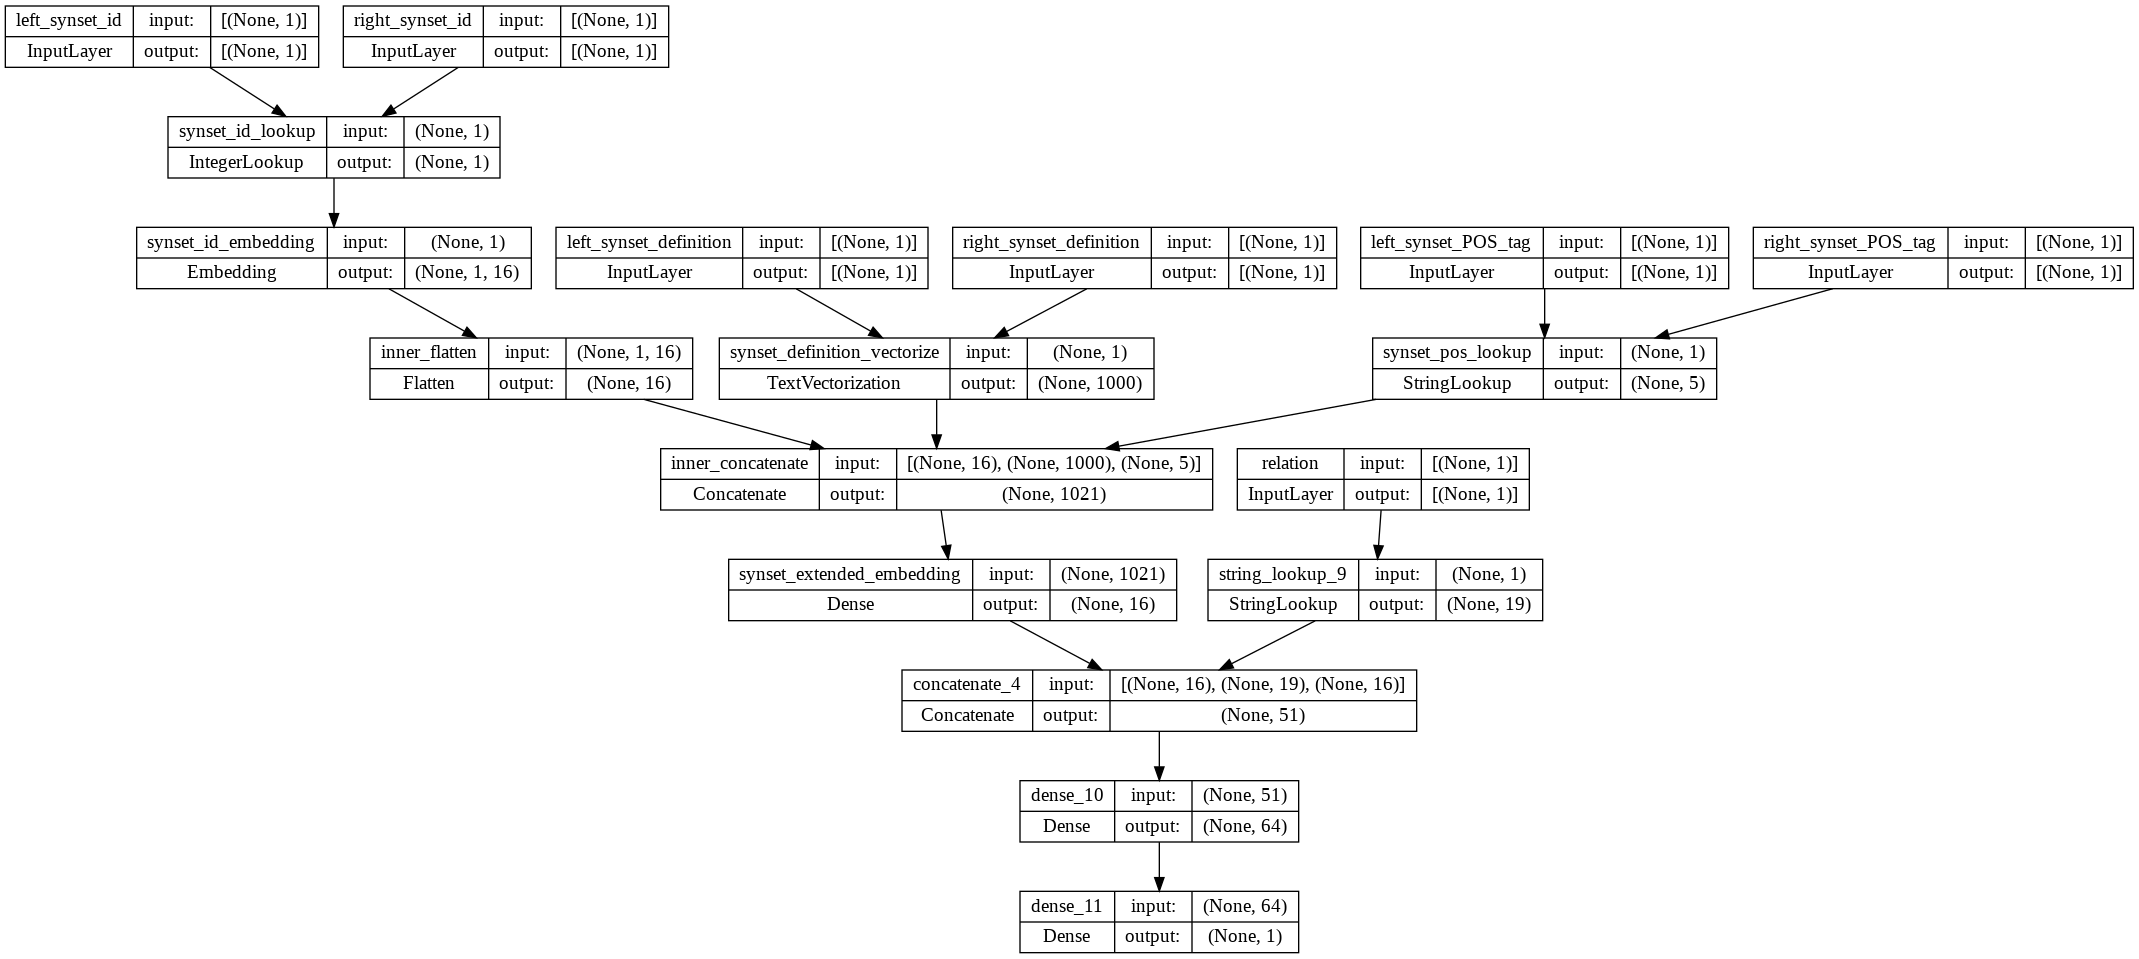

In [105]:
plot_model(model, show_shapes=True)

In [106]:
def to_X_dict(X: pd.DataFrame) -> pd.DataFrame:
  return {
    'left_synset_id': X.left_synset_id,
    'left_synset_POS_tag': X.left_POS_tag,
    'left_synset_definition': X.left_definition,
    'relation': X.relation,
    'right_synset_id': X.right_synset_id,
    'right_synset_POS_tag': X.right_POS_tag,
    'right_synset_definition': X.right_definition,
  }

In [107]:
BATCH_SIZE = 4096

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
)

history = model.fit(
  x=to_X_dict(X_train),
  y=y_train,
  batch_size=BATCH_SIZE,
  validation_data=(
      to_X_dict(X_valid),
      y_valid,
  ),
  epochs=30,
  callbacks=[callback],
)

Epoch 1/30
173/173 [==============================] - 45s 258ms/step - loss: 0.4047 - accuracy: 0.8180 - val_loss: 0.3008 - val_accuracy: 0.8622
Epoch 2/30
173/173 [==============================] - 44s 254ms/step - loss: 0.2424 - accuracy: 0.8938 - val_loss: 0.2244 - val_accuracy: 0.8988
Epoch 3/30
173/173 [==============================] - 44s 253ms/step - loss: 0.1917 - accuracy: 0.9188 - val_loss: 0.2044 - val_accuracy: 0.9092
Epoch 4/30
173/173 [==============================] - 43s 248ms/step - loss: 0.1672 - accuracy: 0.9308 - val_loss: 0.1847 - val_accuracy: 0.9215
Epoch 5/30
173/173 [==============================] - 43s 251ms/step - loss: 0.1435 - accuracy: 0.9425 - val_loss: 0.1647 - val_accuracy: 0.9311
Epoch 6/30
173/173 [==============================] - 44s 253ms/step - loss: 0.1195 - accuracy: 0.9545 - val_loss: 0.1476 - val_accuracy: 0.9392
Epoch 7/30
173/173 [==============================] - 43s 248ms/step - loss: 0.0988 - accuracy: 0.9643 - val_loss: 0.1347 - val_ac

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

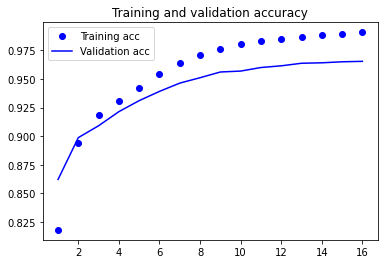

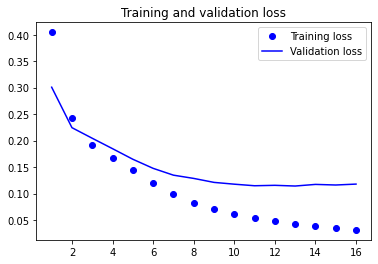

In [109]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [110]:
y_pred = model.predict(to_X_dict(X_test), batch_size=128)

196/196 [==============================] - 16s 83ms/step


In [111]:
print(classification_report(y_test.values, y_pred.flatten() > 0.5, target_names=['Invalid', 'Valid']))

              precision    recall  f1-score   support

     Invalid       0.98      0.97      0.98     20000
       Valid       0.88      0.93      0.91      5000

    accuracy                           0.96     25000
   macro avg       0.93      0.95      0.94     25000
weighted avg       0.96      0.96      0.96     25000

